In [50]:
import rasterio
from rasterio.plot import show
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Sources

https://gis.stackexchange.com/questions/346288/extract-all-pixels-values-from-geotiff-with-python

https://rasterio.readthedocs.io/en/latest/quickstart.html#reading-raster-data


In [2]:
# read in the geotiff
raster = rasterio.open('pop_density_image_to_data.tif')

In [9]:
print('The name of the raster is: ', raster.name)
print("The shape of the image is: ", raster.shape)
print('The number of bands in the raster is: ', raster.count)
print('The current mode out of read (r) and write(w) is: ', raster.mode)
print('The current crs for the raster is: ', raster.crs)
print('The current bounding box of the raster is: ', raster.bounds)

The name of the raster is:  pop_density_image_to_data.tif
The shape of the image is:  (447, 446)
The number of bands in the raster is:  5
The current mode out of read (r) and write(w) is:  r
The current crs for the raster is:  EPSG:4326
The current bounding box of the raster is:  BoundingBox(left=32.39946240778792, bottom=0.09930131117056085, right=32.80011102450523, top=0.500848243171987)


In [33]:
print('Raster width: ',raster.width)
print('Raster height: ', raster.height)
print('Raster left bound: ', raster.bounds.left) # repeat for top, left, right

Raster width:  446
Raster height:  447
Raster left bound:  32.39946240778792


## The raster has 1 band which is broken into 5 columns from 1 to 5 from 00, 05, 10, 15, 20. This is known from the source data in Earth Engine. But rasterio is treating this as 5 bands, lets go with that.

In [10]:
# Generating a 2D arry of values for a specific band
band_no = 5  # this assumes you want the fifth band, change to match the band number you want
band_array = raster.read(band_no)  # band_arr is a numpy array of shape (raster.width, raster.height)
band_array

array([[272.2379 , 271.1793 , 271.1793 , ..., 406.65363, 406.65363,
        406.65363],
       [302.2908 , 272.0862 , 272.0862 , ..., 406.6536 , 406.6536 ,
        406.6536 ],
       [302.2908 , 272.0862 , 272.0862 , ..., 406.6536 , 406.6536 ,
        406.6536 ],
       ...,
       [220.09372, 220.09372, 220.09372, ...,   0.     ,   0.     ,
          0.     ],
       [220.09372, 220.09372, 220.09372, ...,   0.     ,   0.     ,
          0.     ],
       [220.09373, 220.09373, 220.09373, ...,   0.     ,   0.     ,
          0.     ]], dtype=float32)

In [34]:
band_array[446, 0]

220.09373

## We can pull out a value by feeding in the index values 

In [15]:
# Creating a dict of x, references and the value
px_vals = []

for x in range(band_array.shape[0]):
    for y in range(band_array.shape[1]):
        px_vals.append({'x': x, 
                        'y': y,
                        'value': band_array[x, y]})

In [18]:
# Looking at the first five values
px_vals[0:5]

[{'x': 0, 'y': 0, 'value': 272.2379},
 {'x': 0, 'y': 1, 'value': 271.1793},
 {'x': 0, 'y': 2, 'value': 271.1793},
 {'x': 0, 'y': 3, 'value': 271.1793},
 {'x': 0, 'y': 4, 'value': 271.1793}]

In [12]:
# Looking them up one by one eg x=420, y=5
band_array[420, 5]

220.09372

## Linking values back to lat and long: Raster transform

## Raster.trasnform is a powerful function that conducts an afine transformation matrix on your index values and generates the lat and long coordinates.

In [36]:
raster.transform

Affine(0.0008983152841195215, 0.0, 32.39946240778792,
       0.0, -0.0008983152841195215, 0.500848243171987)

In [23]:
# For example conducting transfomr on the 0,0 coordinates give us the coordinates of the TOP LEFT corner
print('coordinates of the top lef hand corner of bounding box: ', raster.transform * (0, 0))
print('coordinates of the bottom lef hand corner of bounding box: ', raster.transform * (0, 446))

coordinates of the top lef hand corner of bounding box:  (32.39946240778792, 0.500848243171987)
coordinates of the bottom lef hand corner of bounding box:  (32.39946240778792, 0.10019962645468034)


## Why does this matter? lets try and visualise

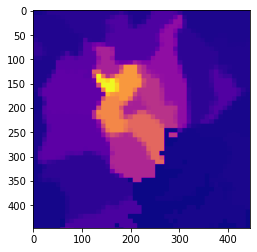

In [27]:
# Generate an image of the raster, band 5 using 'plasma' colour map
# Note the values are based on index number starting int he top left. Not so helpful
plt.imshow(raster.read(5), cmap='plasma')
plt.show()

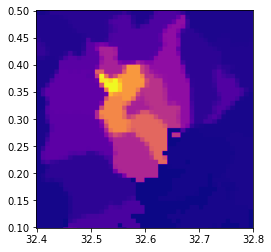

In [31]:
# Conducting the transform and then plotting using rasterio plotting tool - now the indexes are how we want them
show(raster.read(5), transform=raster.transform, cmap = 'plasma');

## Now, finally extracting a value from the coordinates

In [38]:
def value_from_long_lat( long, lat):
    row, col = raster.index(long, lat)
    band_array = raster.read(5)
    value = band_array[row,col]
    return value

In [39]:
# For example (32.8, 0.1 in Murchison bay)
value_from_long_lat(32.8, 0.1)

0.0

In [41]:
# For example (32.52, 0.356 in the Kawempe hotspot)
value_from_long_lat(32.53, 0.356)

10835.025

In [ ]:
Finally putting the lat long and coordinates in the same grid

In [47]:
# Creating a dict of x,y references and the value
px_vals = []

for x in range(band_array.shape[0]):
    for y in range(band_array.shape[1]):
        px_vals.append({'x': x, 
                        'y': y,
                        'lat': (raster.transform * (x,y))[1],
                        'lon': (raster.transform * (x,y))[0],
                        'value': band_array[x, y]})

In [55]:
px_vals[0:5]

[{'x': 0,
  'y': 0,
  'lat': 0.500848243171987,
  'lon': 32.39946240778792,
  'value': 272.2379},
 {'x': 0,
  'y': 1,
  'lat': 0.4999499278878674,
  'lon': 32.39946240778792,
  'value': 271.1793},
 {'x': 0,
  'y': 2,
  'lat': 0.4990516126037479,
  'lon': 32.39946240778792,
  'value': 271.1793},
 {'x': 0,
  'y': 3,
  'lat': 0.4981532973196284,
  'lon': 32.39946240778792,
  'value': 271.1793},
 {'x': 0,
  'y': 4,
  'lat': 0.4972549820355089,
  'lon': 32.39946240778792,
  'value': 271.1793}]

In [51]:
df = pd.DataFrame.from_dict(px_vals)
df

,x,y,lat,lon,value
0,0,0,0.500848,32.399462,272.237915
1,0,1,0.499950,32.399462,271.179291
2,0,2,0.499052,32.399462,271.179291
3,0,3,0.498153,32.399462,271.179291
4,0,4,0.497255,32.399462,271.179291
...,...,...,...,...,...
199357,446,441,0.104691,32.800111,0.000000
199358,446,442,0.103793,32.800111,0.000000
199359,446,443,0.102895,32.800111,0.000000
199360,446,444,0.101996,32.800111,0.000000


In [53]:
df.to_csv('pop_density_kampala.csv')